## 1. Descriptive Analysis

- 1.1 Load and Explore Data
- 1.2. Data cleaning
- 1.3. Statistical Summary of Sales Data\*\*
- 1.4. Plot count of transactions recorded under each sales channel
- 1.5. Profit Distribution for Different Sales Channels
- 1.6. Plot The average Delivery time for Different Sales Channels
- 1.7. Visualize the Order Fulfillment Analysis by Warehouse and Sales Channel
- 1.8. Comparative Analysis of Profit Contribution by Warehouse
- 1.9. Total Profit by WarehouseCode and Sales Channel Analysis
- 1.10. Trend Analysis of Monthly Profits from May 2018 to December 2020
- 1.11. Impact of Delivery Time on Profit Generation
- 1.12. Performance Analysis of Sales Teams by Total Profit
- 1.13. Profit generated by each product
- 1.14. ScatterPlot analysis of Delivery Time Versus Profit with Order Quantity as a Factor

## 2. Predictive modeling and model performance evaluation (profit prediction)

- 2.2 Data Preparation and Cleaning:
  - Remove irrelevant features such as 'OrderNumber', 'ProcuredDate', etc., to streamline the dataset.
  - Summarize the preprocessing steps, such as label encoding categorical variables and standardizing key numerical features like 'Profit', 'Unit Cost', and 'Unit Price'.
- 2.3 Feature Engineering: transformation of categorical data using label encoding and feature scaling contributes to better model performance.
- 2.4 Model Building: LGBMRegressor model, specifying parameters such as 'n_jobs' and 'random_state' for reproducibility and performance optimization.
- 2.5 Model Training and Evaluation:
  - Describe the training process using a train-test split and evaluate the model using the R2 score to quantify its accuracy.
  - Illustrate the model's learning curve to assess its performance over different training sizes, aiding in understanding if more data could improve model performance.


#### 1.1 Load and Explore Data


In [29]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy as sp
import re

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor, Dataset

In [30]:
# Read dataset
df = pd.read_csv("./US_Regional_Sales_Data.csv")
df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.08,"$1,001.18","$1,963.10"
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/2018,USD,14,20,196,27,3,0.08,"$3,348.66","$3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/2018,USD,21,16,213,16,1,0.05,$781.22,"$1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/2018,7/6/2018,USD,28,48,107,23,8,0.08,"$1,464.69","$2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,10/4/2018,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.10,"$1,476.14","$1,822.40"


In [31]:
# Parse dates
date_col = ['ProcuredDate', 'OrderDate', 'ShipDate', 'DeliveryDate']


def parse_date(date_str):
    formats = ['%d/%m/%y', '%d/%m/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if none of the formats match


for col in date_col:
    df[col] = df[col].apply(parse_date)

df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-14,2018-06-19,USD,6,15,259,12,5,0.08,"$1,001.18","$1,963.10"
1,SO - 000102,Online,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-22,2018-07-02,USD,14,20,196,27,3,0.08,"$3,348.66","$3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-21,2018-07-01,USD,21,16,213,16,1,0.05,$781.22,"$1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-02,2018-06-07,USD,28,48,107,23,8,0.08,"$1,464.69","$2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,2018-04-10,2018-05-31,2018-06-16,2018-06-26,USD,22,49,111,26,8,0.10,"$1,476.14","$1,822.40"


In [32]:
# Perform initial data cheking:
def initial_data_checking(df):
    # Print the shape of the DataFrame (number of rows and columns)
    print("\nShape of the DataFrame:\n")
    print(df.shape)

    # Print the count of duplicate rows
    print("\nDuplicate Rows Number:\n")
    print(df.duplicated().sum())

    # Print summary statistics for numerical columns
    print("\nSummary Statistics:\n")
    return pd.DataFrame(df.describe())


initial_data_checking(df)


Shape of the DataFrame:

(7991, 16)

Duplicate Rows Number:

0

Summary Statistics:



,ProcuredDate,OrderDate,ShipDate,DeliveryDate,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied
count,7991,7991,7991,7991,7991.000000,7991.000000,7991.000000,7991.000000,7991.000000,7991.000000
mean,2019-05-29 05:11:01.794518784,2019-09-15 11:01:09.828557312,2019-09-30 15:04:26.249530624,2019-10-06 03:10:06.832686592,14.384307,25.457014,183.850081,23.771743,4.525341,0.115649
min,2017-12-31 00:00:00,2018-05-31 00:00:00,2018-06-02 00:00:00,2018-06-07 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,0.050000
25%,2018-10-27 00:00:00,2019-01-16 12:00:00,2019-01-31 00:00:00,2019-02-06 00:00:00,8.000000,13.000000,91.000000,12.000000,3.000000,0.050000
50%,2019-05-15 00:00:00,2019-09-15 00:00:00,2019-09-30 00:00:00,2019-10-05 00:00:00,14.000000,25.000000,183.000000,24.000000,5.000000,0.080000
75%,2020-03-10 00:00:00,2020-05-12 00:00:00,2020-05-28 00:00:00,2020-06-01 00:00:00,21.000000,38.000000,276.000000,36.000000,7.000000,0.150000
max,2020-09-26 00:00:00,2020-12-30 00:00:00,2021-01-24 00:00:00,2021-02-02 00:00:00,28.000000,50.000000,367.000000,47.000000,8.000000,0.400000
std,NaN,NaN,NaN,NaN,7.986086,14.414883,105.903946,13.526545,2.312631,0.085018


In [33]:
# Check datatypes, missing and unique values
def unique_and_missing_values_dtype(df):
    # Non-null counts and data types
    non_null_counts = df.notnull().sum()
    dtypes = df.dtypes

    # Count of unique values
    unique_count = df.nunique()

    # Percentage of unique values
    unique_percentage = (df.nunique() / len(df)) * 100

    # Count of missing values
    missing_count = df.isnull().sum()

    # Percentage of missing values
    missing_percentage = df.isnull().mean() * 100

    # Combine into a DataFrame
    summary = pd.DataFrame({
        'non-Null_count': non_null_counts,
        'dtype': dtypes,
        'unique_values': unique_count,
        '%_unique': unique_percentage.round(2).astype(str) + '%',
        'missing_values': missing_count,
        '%_missing': missing_percentage.round(2).astype(str) + '%'
    })

    return summary


unique_and_missing_values_dtype(df)

,non-Null_count,dtype,unique_values,%_unique,missing_values,%_missing
OrderNumber,7991,object,7991,100.0%,0,0.0%
Sales Channel,7991,object,4,0.05%,0,0.0%
WarehouseCode,7991,object,6,0.08%,0,0.0%
ProcuredDate,7991,datetime64[ns],11,0.14%,0,0.0%
OrderDate,7991,datetime64[ns],945,11.83%,0,0.0%
ShipDate,7991,datetime64[ns],966,12.09%,0,0.0%
DeliveryDate,7991,datetime64[ns],966,12.09%,0,0.0%
CurrencyCode,7991,object,1,0.01%,0,0.0%
_SalesTeamID,7991,int64,28,0.35%,0,0.0%
_CustomerID,7991,int64,50,0.63%,0,0.0%


### 1.2. Data cleaning


In [34]:
# Calculate the 'Delivery_time' by subtracting the 'OrderDate' from the 'DeliveryDate'. The result is converted to days using '.dt.days' which extracts the number of days between these dates.
df['Delivery_time'] = (df['DeliveryDate'] - df['OrderDate']).dt.days

# Convert the 'Unit Cost' column from a string to a numeric format. This involves removing any dollar signs ('$')  and commas (',') to ensure the data can be processed as numbers. The 'str.replace()' function is used for  string manipulations, and 'pd.to_numeric()' converts the cleaned string values to numeric type (float or int).
df['Unit Cost'] = pd.to_numeric(
    df['Unit Cost'].str.replace('$', '').str.replace(',', ''))

# Similar to 'Unit Cost', convert the 'Unit Price' column from a string format that includes currency symbols and commas into a numeric format for easier calculation and analysis in subsequent operations.
df['Unit Price'] = pd.to_numeric(
    df['Unit Price'].str.replace('$', '').str.replace(',', ''))
df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price,Delivery_time
0,SO - 000101,In-Store,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-14,2018-06-19,USD,6,15,259,12,5,0.08,1001.18,1963.1,19
1,SO - 000102,Online,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-22,2018-07-02,USD,14,20,196,27,3,0.08,3348.66,3939.6,32
2,SO - 000103,Distributor,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-21,2018-07-01,USD,21,16,213,16,1,0.05,781.22,1775.5,31
3,SO - 000104,Wholesale,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-02,2018-06-07,USD,28,48,107,23,8,0.08,1464.69,2324.9,7
4,SO - 000105,Distributor,WARE-NMK1003,2018-04-10,2018-05-31,2018-06-16,2018-06-26,USD,22,49,111,26,8,0.10,1476.14,1822.4,26


In [35]:
# Generate descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution, excluding NaN values.
df.describe().T

,count,mean,min,25%,50%,75%,max,std
ProcuredDate,7991,2019-05-29 05:11:01.794518784,2017-12-31 00:00:00,2018-10-27 00:00:00,2019-05-15 00:00:00,2020-03-10 00:00:00,2020-09-26 00:00:00,NaN
OrderDate,7991,2019-09-15 11:01:09.828557312,2018-05-31 00:00:00,2019-01-16 12:00:00,2019-09-15 00:00:00,2020-05-12 00:00:00,2020-12-30 00:00:00,NaN
ShipDate,7991,2019-09-30 15:04:26.249530624,2018-06-02 00:00:00,2019-01-31 00:00:00,2019-09-30 00:00:00,2020-05-28 00:00:00,2021-01-24 00:00:00,NaN
DeliveryDate,7991,2019-10-06 03:10:06.832686592,2018-06-07 00:00:00,2019-02-06 00:00:00,2019-10-05 00:00:00,2020-06-01 00:00:00,2021-02-02 00:00:00,NaN
_SalesTeamID,7991.0,14.384307,1.0,8.0,14.0,21.0,28.0,7.986086
_CustomerID,7991.0,25.457014,1.0,13.0,25.0,38.0,50.0,14.414883
_StoreID,7991.0,183.850081,1.0,91.0,183.0,276.0,367.0,105.903946
_ProductID,7991.0,23.771743,1.0,12.0,24.0,36.0,47.0,13.526545
Order Quantity,7991.0,4.525341,1.0,3.0,5.0,7.0,8.0,2.312631
Discount Applied,7991.0,0.115649,0.05,0.05,0.08,0.15,0.4,0.085018


### **Statistical Summary of Sales Data**

This dataset provides a comprehensive statistical overview of various attributes related to order processing and sales performance:

1. Date Ranges:

- ProcuredDate: Varies from December 31, 2017, to September 26, 2020.
- OrderDate: Ranges from May 31, 2018, to December 30, 2020.
- ShipDate: Spans from June 2, 2018, to January 24, 2021.
- DeliveryDate: Extends from June 7, 2018, to February 2, 2021.

2. Sales Metrics:

- SalesTeamID and CustomerID: Display a broad range of identifiers, with maximum values at 28 and 50, respectively, showing varied involvement across teams and customers.
- StoreID and ProductID: Vary significantly, with maxima of 367 and 47, pointing to a wide product range and numerous store locations involved.

3. Order Details:

- Order Quantity: Generally low (median at 5), with a maximum of 8, suggesting limits on order sizes or commonly purchased quantities.
- Discount Applied: Ranges from 0.05 to 0.4 with a median of 0.08, indicating typical discounting practices.
- Unit Cost and Unit Price: Show significant variability with maximums reaching $5498.56 and $6566.00 respectively, which highlights the diverse range of products and their pricing strategies.
- Delivery Time: Averages around 21 days, with a range from 3 to 38 days, which could indicate logistical challenges or efficiencies depending on the context.


In [36]:
df['Profit'] = round((df['Unit Price']-df['Unit Cost']) *
                     df['Order Quantity']*(1-df['Discount Applied']), 2)
df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price,Delivery_time,Profit
0,SO - 000101,In-Store,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-14,2018-06-19,USD,6,15,259,12,5,0.08,1001.18,1963.1,19,4424.83
1,SO - 000102,Online,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-22,2018-07-02,USD,14,20,196,27,3,0.08,3348.66,3939.6,32,1630.99
2,SO - 000103,Distributor,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-21,2018-07-01,USD,21,16,213,16,1,0.05,781.22,1775.5,31,944.57
3,SO - 000104,Wholesale,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-02,2018-06-07,USD,28,48,107,23,8,0.08,1464.69,2324.9,7,6331.15
4,SO - 000105,Distributor,WARE-NMK1003,2018-04-10,2018-05-31,2018-06-16,2018-06-26,USD,22,49,111,26,8,0.10,1476.14,1822.4,26,2493.07


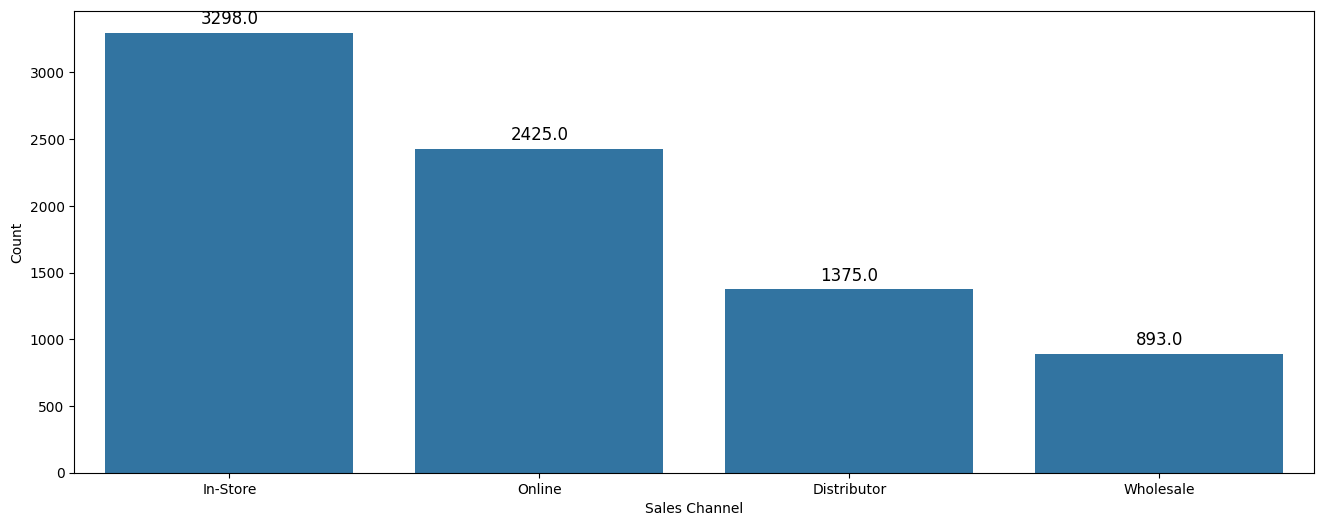

In [37]:
# Plot count of transactions recorded under each sales channel:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='Sales Channel', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
plt.xlabel('Sales Channel')
plt.ylabel('Count')
plt.show()

### **Transactions distribution recorded under each sales channel:**

In-Store (3298) and Online (2425) channels dominate in popularity, significantly outpacing Distributor (1375) and Wholesale (893) channels. This disparity suggests a focused customer preference towards direct retail experiences, either physically in-store or via digital platforms, highlighting potential areas for targeted business development and resource allocation.


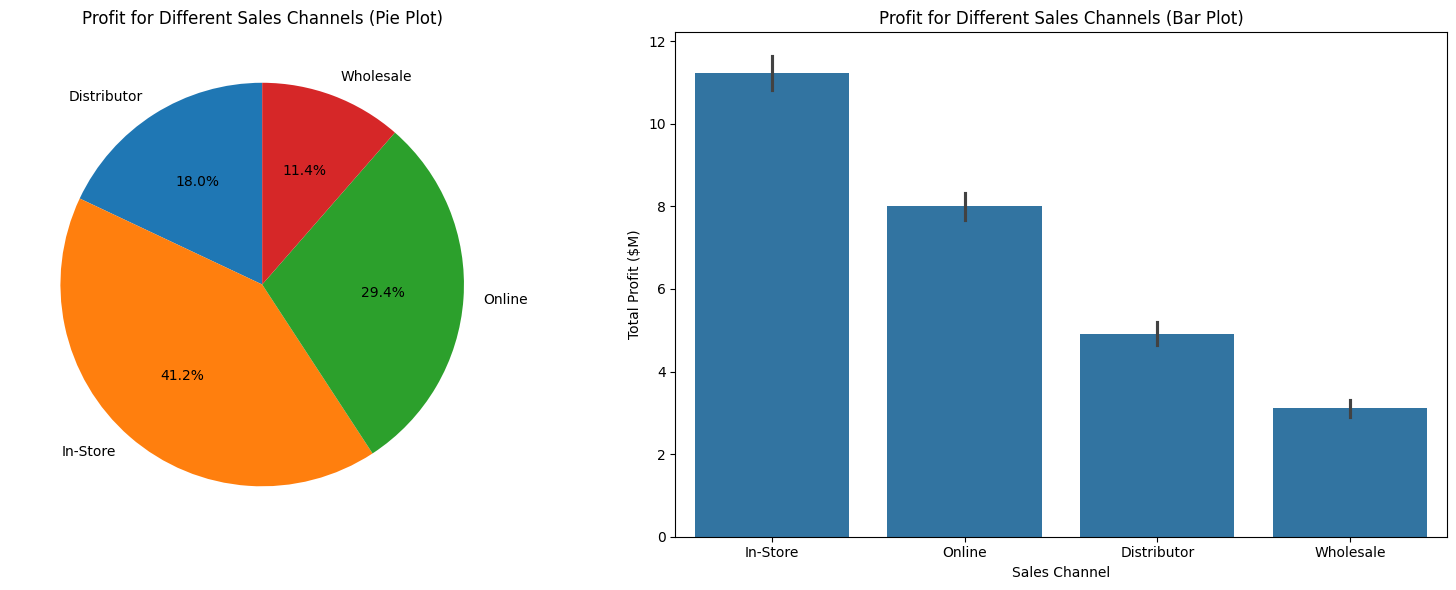

In [38]:
# Plot profit for different channels:
# Convert the 'Profit' values from units to millions for easier interpretation
df['Profit'] = df['Profit'] / 1e6  # Divide each profit value by one million

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting Profit for Different Sales Channels (Pie Plot)
# Here, the profits are converted to percentages automatically by the pie plot function
df.groupby('Sales Channel')['Profit'].sum().plot.pie(
    autopct='%1.1f%%', startangle=90, ax=axes[0])
axes[0].set_title('Profit for Different Sales Channels (Pie Plot)')
axes[0].set_ylabel('')

# Plotting Profit for Different Sales Channels (Bar Plot)
sns.barplot(x='Sales Channel', y='Profit', data=df, estimator=sum, ax=axes[1])
axes[1].set_title('Profit for Different Sales Channels (Bar Plot)')
axes[1].set_xlabel('Sales Channel')
axes[1].set_ylabel('Total Profit ($M)')

plt.tight_layout()
plt.show()

### **Profit Distribution for Different Sales Channels**

The pie chart shows that In-Store sales generate the largest share of profit (41.2%), followed by Online (29.4%). The visual analysis emphasizes the dominance of In-Store and Online channels in profitability, which suggests these areas are pivotal to the business's revenue strategy. Strategic investments in these channels could further enhance profitability and market position.


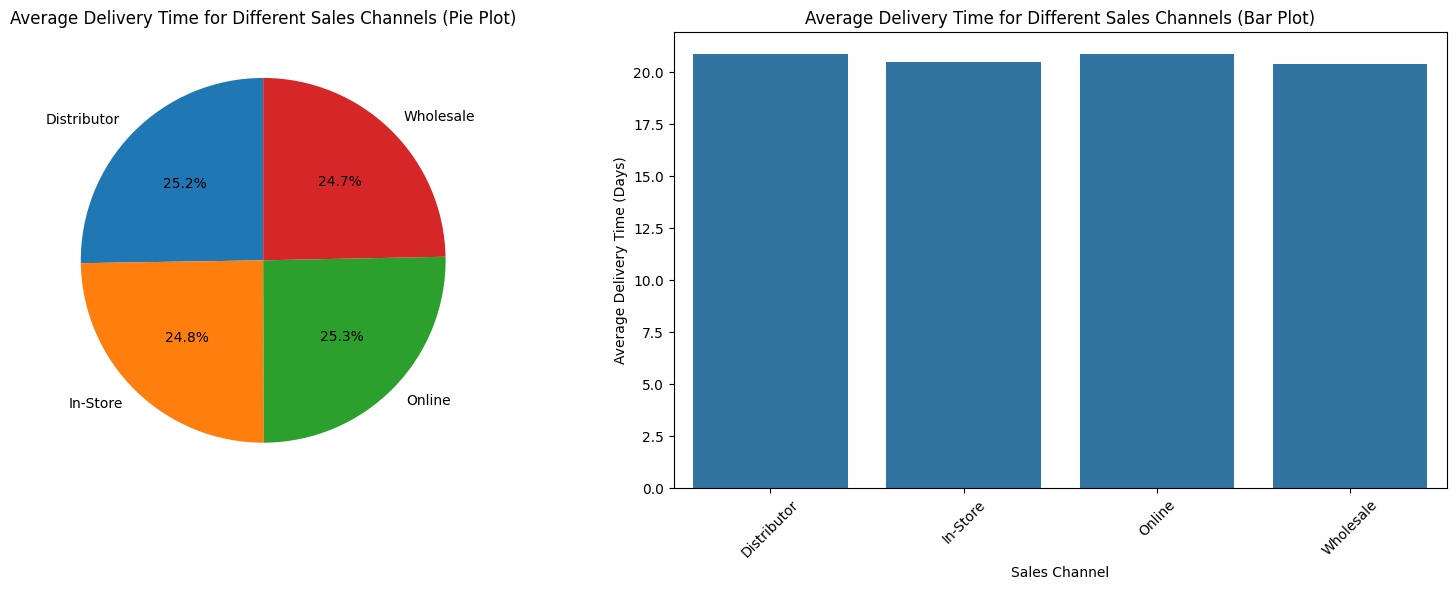

In [39]:
# Plot The average Delivery time for Different Sales Channels:
avg_delivery_time = df.groupby('Sales Channel')['Delivery_time'].mean()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting Average Delivery Time for Different Sales Channels (Pie Plot)
avg_delivery_time.plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[0])
axes[0].set_title(
    'Average Delivery Time for Different Sales Channels (Pie Plot)')
axes[0].set_ylabel('')

# Plotting Average Delivery Time for Different Sales Channels (Bar Plot)
sns.barplot(x=avg_delivery_time.index, y=avg_delivery_time.values, ax=axes[1])
axes[1].set_title(
    'Average Delivery Time for Different Sales Channels (Bar Plot)')
axes[1].set_xlabel('Sales Channel')
axes[1].set_ylabel('Average Delivery Time (Days)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### **Average Delivery Time for Different Sales Channels**

The pie chart shows an even distribution of delivery times across these channels, each contributing around 24% to 25%. The bar chart reveals that all channels have a uniform average delivery time, consistently around 19 days. This uniformity suggests that delivery operations are standardized across all sales channels, which may indicate efficient logistical management.


/var/folders/76/0pntsdld7bg_p5gzgms4gghw0000gn/T/ipykernel_8529/224814089.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='WarehouseCode', palette='Dark2', ax=axes[0])


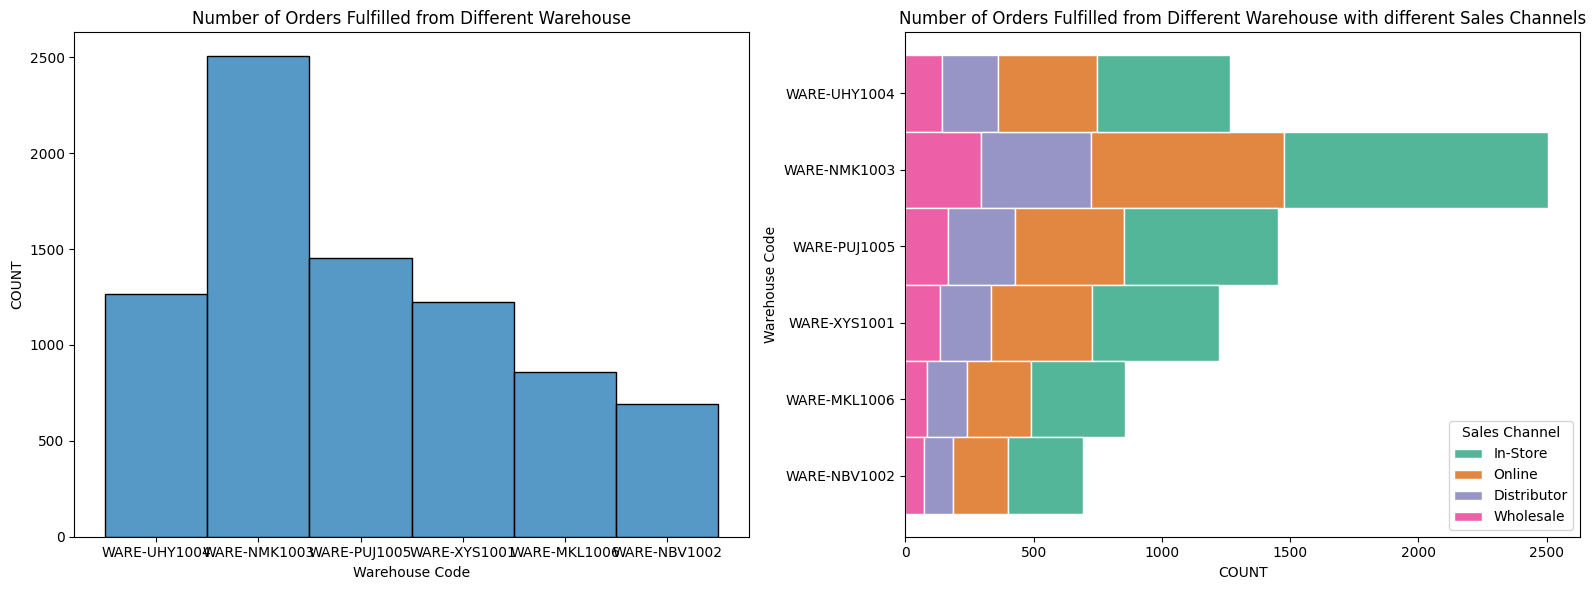

In [40]:
# Visualize the Order Fulfillment Analysis by Warehouse and Sales Channel:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting Number of Orders Fulfilled from Different Warehouse using Seaborn
sns.histplot(data=df, x='WarehouseCode', palette='Dark2', ax=axes[0])
axes[0].set_title('Number of Orders Fulfilled from Different Warehouse')
axes[0].set_xlabel('Warehouse Code')
axes[0].set_ylabel('COUNT')

# Plotting Number of Orders Fulfilled from Different Warehouse using Seaborn (Stacked Bar Plot)
sns.histplot(data=df, y='WarehouseCode', hue='Sales Channel',
             multiple='stack', palette='Dark2', edgecolor='w', ax=axes[1])
axes[1].set_title(
    'Number of Orders Fulfilled from Different Warehouse with different Sales Channels')
axes[1].set_xlabel('COUNT')
axes[1].set_ylabel('Warehouse Code')

plt.tight_layout()
plt.show()

### **Order Fulfillment Analysis by Warehouse and Sales Channel:**

The visuals illustrate the distribution of order fulfillment across various warehouses and the impact of different sales channels on each warehouse's operations. The first bar chart shows that WARE-NMK1003 processes the highest number of orders, followed by WARE-PUJ1005, indicating significant operational capacity at these locations. The second stacked bar chart breaks down the order counts from each warehouse by sales channel, revealing that while some warehouses, like WARE-UHY1004 and WARE-NMK1003, predominantly serve Online and In-Store channels, others like WARE-PUJ1005 have a more balanced distribution across all channels, including Distributor and Wholesale. This differentiation may suggest varying strategic focuses or market demands met by each warehouse.


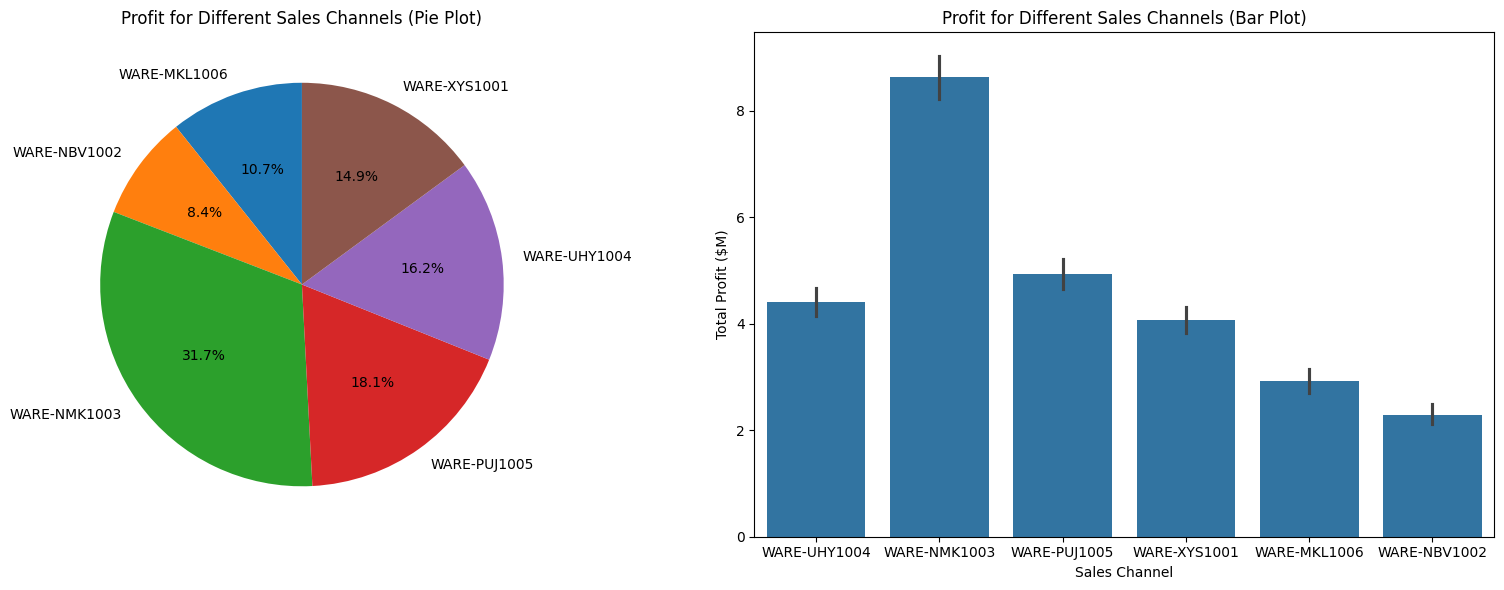

In [41]:
# Comparative Analysis of Profit Contribution by Warehouse
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting Profit for Different Warehouse (Pie Plot)
df.groupby('WarehouseCode')['Profit'].sum().plot.pie(
    autopct='%1.1f%%', startangle=90, ax=axes[0])
axes[0].set_title('Profit for Different Sales Channels (Pie Plot)')
axes[0].set_ylabel('')

# Plotting Profit for Different Warehouse(Bar Plot)
sns.barplot(x='WarehouseCode', y='Profit', data=df, estimator=sum, ax=axes[1])
axes[1].set_title('Profit for Different Sales Channels (Bar Plot)')
axes[1].set_xlabel('Sales Channel')
axes[1].set_ylabel('Total Profit ($M)')

plt.tight_layout()
plt.show()

### **Comparative Analysis of Profit Contribution by Warehouse:**

- The pie chart details the percentage contribution of each warehouse to total profits, with WARE-NMK1003 leading significantly at 31.7%, followed by WARE-PUJ1005 and WARE-UHY1004.
- The bar chart complements this by quantifying these profits, highlighting that WARE-NMK1003 not only leads in percentage but also in actual profit value, achieving the highest among the warehouses. This analysis indicates a varying efficiency and profitability among warehouses, which could guide strategic decisions regarding resource allocation, operational improvements, and potentially expanding capacities at higher-performing locations.


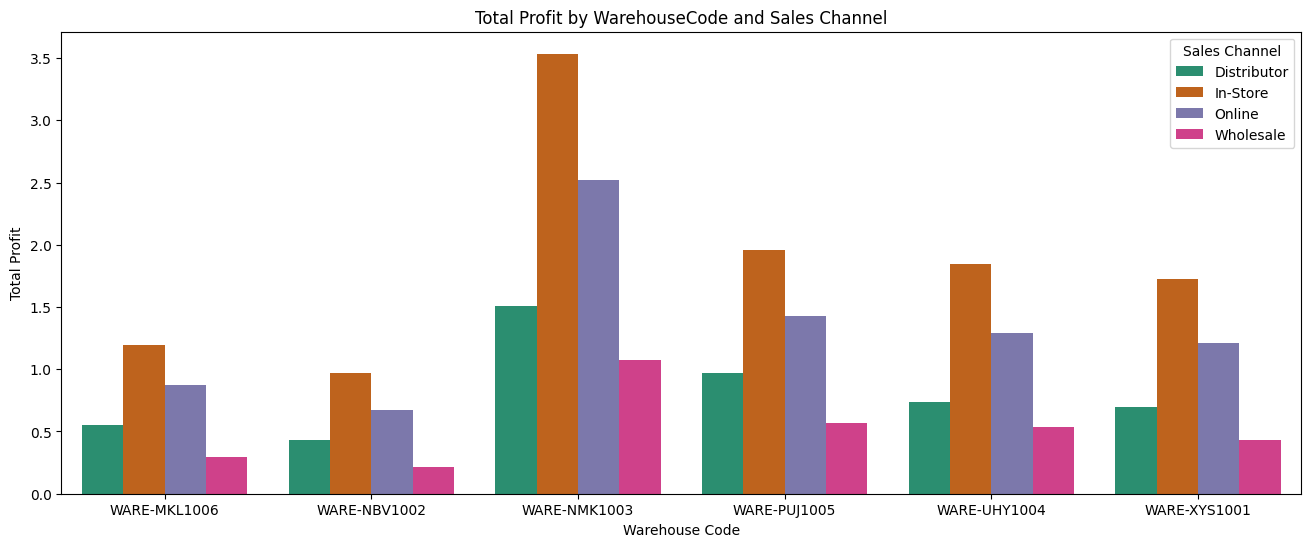

In [42]:
# Total Profit by WarehouseCode and Sales Channel
profit_by_category = df.groupby(['WarehouseCode', 'Sales Channel'])[
    'Profit'].sum().reset_index()

# Plotting total profit for each combination using Seaborn (Bar Plot)
plt.figure(figsize=(16, 6))
sns.barplot(x='WarehouseCode', y='Profit', hue='Sales Channel',
            data=profit_by_category, palette='Dark2')
plt.title('Total Profit by WarehouseCode and Sales Channel')
plt.xlabel('Warehouse Code')
plt.ylabel('Total Profit')
plt.show()

### **Total Profit by WarehouseCode and Sales Channel:**

This visualization illustrates the total profit generated by each warehouse segmented by different sales channels.

- Warehouse WARE-NMK1003 stands out significantly, showing the highest overall profit, predominantly driven by the Distributor channel. This indicates a strong performance in this channel specifically for WARE-NMK1003.
- Other warehouses like WARE-PUJ1005 and WARE-UHY1004 also perform well across multiple channels, particularly In-Store and Online, suggesting a diversified revenue stream.
- In contrast, WARE-MKL1006 and WARE-NBV1002 exhibit lower profit figures across all channels, which might highlight areas for operational review or strategic improvement. The data points to potential strengths and weaknesses in the sales and distribution strategy across different channels and warehouses.


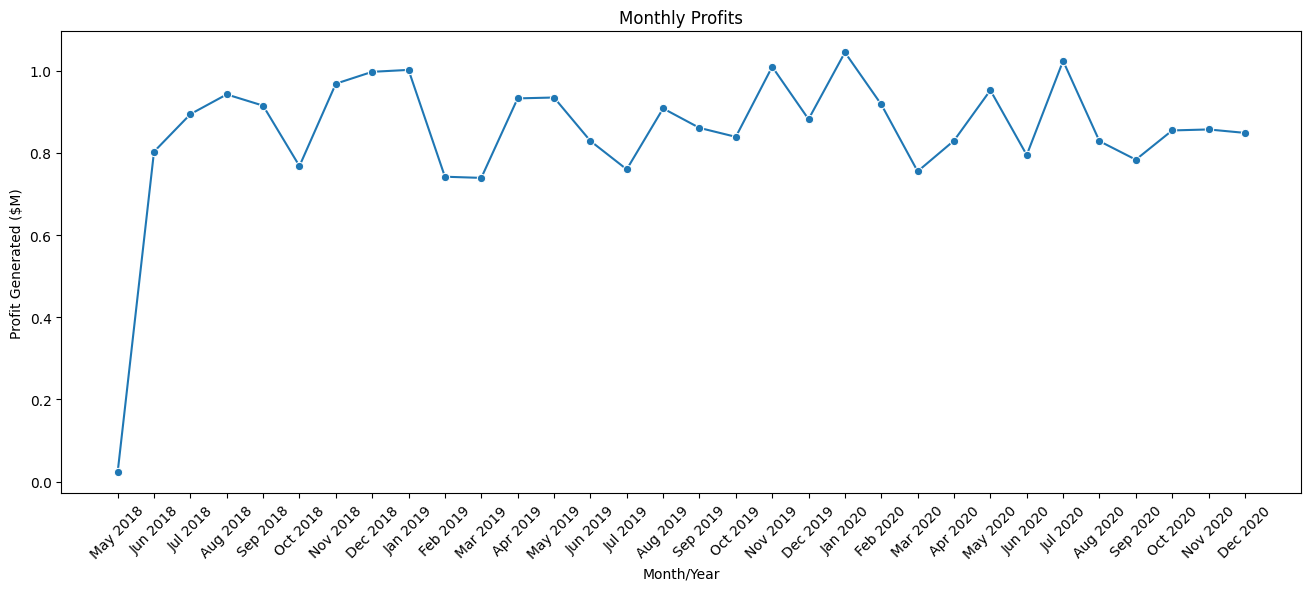

In [43]:
# Trend Analysis of Monthly Profits from May 2018 to December 2020
profit_by_month_year = df.groupby([df['OrderDate'].dt.to_period('M')])[
    'Profit'].sum().reset_index()

# Plotting Profit generated per month for each month/year using Seaborn (Line Plot)
plt.figure(figsize=(16, 6))
sns.lineplot(x=profit_by_month_year.index, y='Profit',
             data=profit_by_month_year, marker='o')

# Format x-axis labels as "Jan 2018", "Feb 2018", etc.
plt.xticks(ticks=profit_by_month_year.index, labels=[date.strftime(
    '%b %Y') for date in profit_by_month_year['OrderDate']], rotation=45)
plt.title('Monthly Profits')
plt.xlabel('Month/Year')
plt.ylabel('Profit Generated ($M)')
plt.show()

### **Trend Analysis of Monthly Profits from May 2018 to December 2020:**

This line graph displays the fluctuation in monthly profits over a span from May 2018 to December 2020. The graph highlights a steep initial increase, peaking in July 2018, followed by significant variability, with notable peaks occurring roughly annually around July. The trend shows seasonal patterns with some dips and recoveries, suggesting impacts from external business cycles or seasonal sales activities. Overall, the graph indicates a relatively stable profit generation with periodic fluctuations that could inform future strategic planning and budgeting cycles.


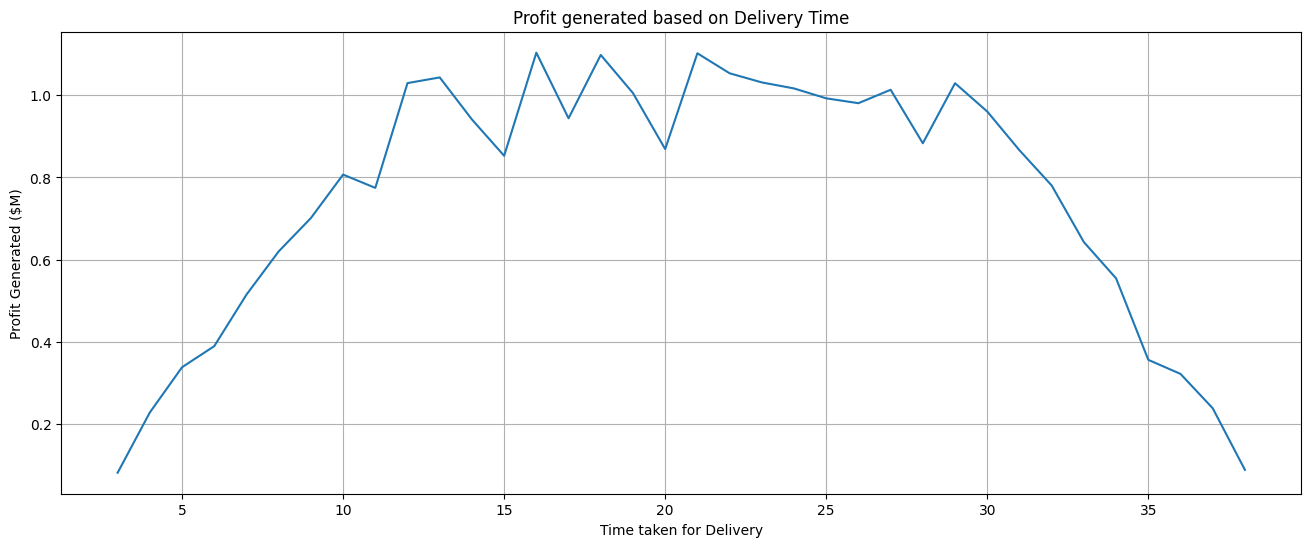

In [44]:
# Impact of Delivery Time on Profit Generation
proift_delivery_time = df.groupby('Delivery_time')[
    'Profit'].sum().reset_index()

plt.figure(figsize=(16, 6))
sns.lineplot(x='Delivery_time', y='Profit', data=proift_delivery_time)
plt.title('Profit generated based on Delivery Time')
plt.xlabel('Time taken for Delivery')
plt.ylabel('Profit Generated ($M)')
plt.grid(True)
plt.show()

### **Impact of Delivery Time on Profit Generation:**

The line graph illustrates how the delivery time impacts profit generation, highlighting a clear trend where shorter delivery times correlate with higher profits. The profit peaks when delivery time is around 20 days and then sharply declines as delivery time increases beyond this point. This suggests that efficiency in delivery processes is crucial for maximizing profit, and delays or extended delivery times could significantly reduce profitability. This analysis underscores the importance of optimizing logistics and delivery strategies to sustain or enhance profit margins.


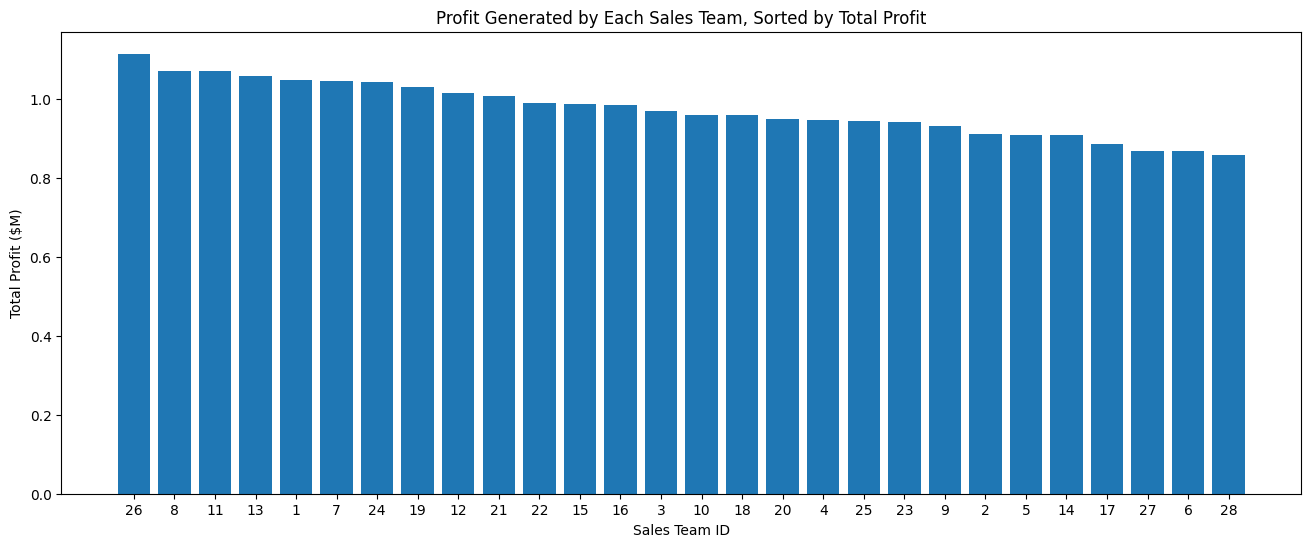

In [45]:
# Performance Analysis of Sales Teams by Total Profit
grouped_df_team = df.groupby('_SalesTeamID')['Profit'].sum().reset_index()
sorted_df_team = grouped_df_team.sort_values(by='Profit', ascending=False)
plt.figure(figsize=(16, 6))
plt.bar(sorted_df_team['_SalesTeamID'].astype(str),
        sorted_df_team['Profit'], color='tab:blue')
plt.title('Profit Generated by Each Sales Team, Sorted by Total Profit')
plt.xlabel('Sales Team ID')
plt.ylabel('Total Profit ($M)')
plt.show()

### **Comparative Profit Analysis Across Sales Teams:**

The visualization reveals that the top-performing teams, like team 26, consistently generate higher profits compared to others. Teams are shown with a gradual decline in profit as we move from the left to the right of the chart, illustrating a significant variation in efficiency and effectiveness across teams. This sorted view allows for easy identification of standout teams and those that may require targeted improvements or further analysis to understand the discrepancies in performance.


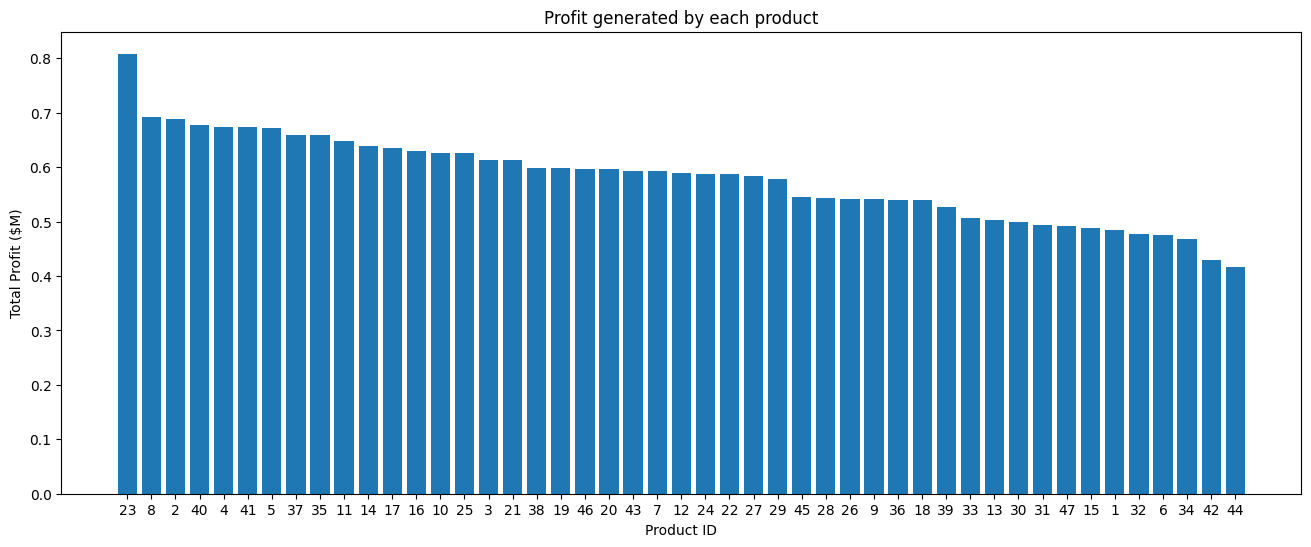

In [46]:
# Profit generated by each product
grouped_df_product = df.groupby('_ProductID')['Profit'].sum().reset_index()
sorted_df_product = grouped_df_product.sort_values(
    by='Profit', ascending=False)
plt.figure(figsize=(16, 6))
plt.bar(sorted_df_product['_ProductID'].astype(str),
        sorted_df_product['Profit'], color='tab:blue')
plt.title('Profit generated by each product')
plt.xlabel('Product ID')
plt.ylabel('Total Profit ($M)')
plt.show()

### **Profit Distribution Across Products**

This bar chart presents the total profit generated by each product, sorted in descending order. Product 23 emerges as the highest profit generator, while the graph shows a gradual decrease in profit across subsequent products, with product 44 yielding the least. This visual distribution indicates the varying financial success of each product, which could be critical for strategic decisions regarding inventory management, marketing focus, and product development. Identifying top performers and underperformers enables the company to allocate resources more efficiently and potentially adjust product lines to maximize overall profitability.


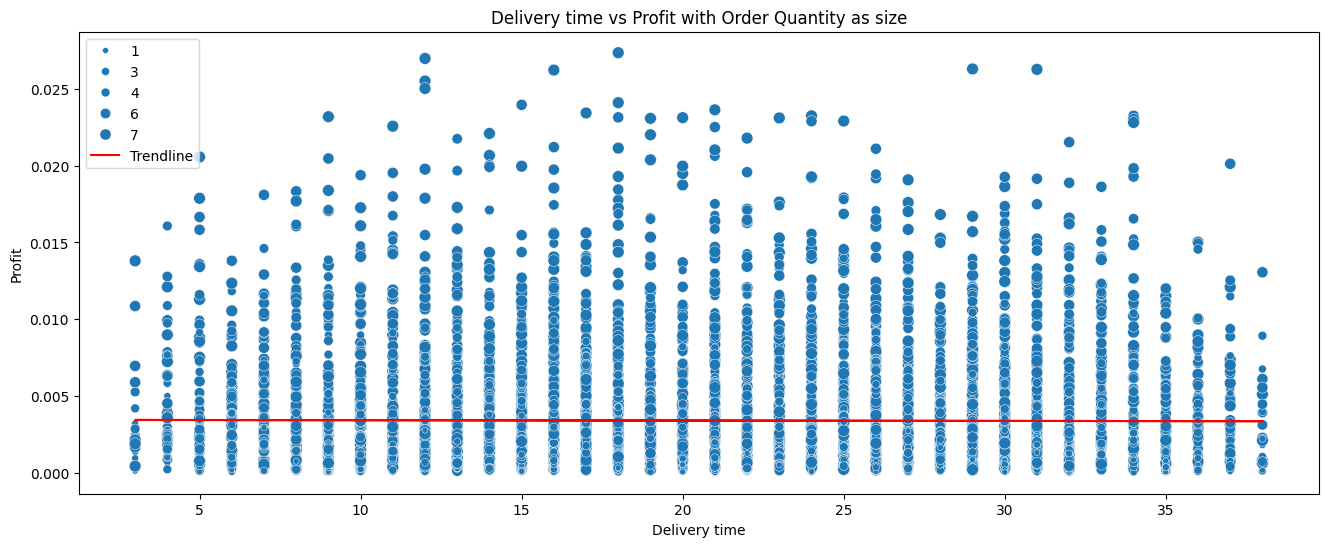

In [47]:
# ScatterPlot Delivery time vs Profit with Order Quantity as size
coefficients = np.polyfit(df['Delivery_time'], df['Profit'], 1)
trendline = np.polyval(coefficients, df['Delivery_time'])


plt.figure(figsize=(16, 6))
sns.scatterplot(x='Delivery_time', y='Profit', size='Order Quantity', data=df)
plt.plot(df['Delivery_time'], trendline, color='red', label='Trendline')
plt.title('Delivery time vs Profit with Order Quantity as size')
plt.xlabel('Delivery time')
plt.ylabel('Profit')
plt.legend()
plt.show()

### **Analysis of Delivery Time Versus Profit with Order Quantity as a Factor**

The scatter plot illustrates the relationship between delivery time and profit, with the size of each point representing the order quantity. The distribution of data points suggests that while there are variations in profit at different delivery times, the overall trend, indicated by the flat red trendline, shows no significant correlation between delivery time and profit. Notably, most transactions, regardless of delivery time, cluster around lower profit margins. This analysis implies that while delivery efficiency does not directly impact profit levels, the size of the order (as visualized by the size of the dots) varies significantly, which might affect profitability on a per-order basis. Businesses could leverage this insight to optimize delivery processes or adjust order management strategies to enhance profitability


## 2. Predictive modeling and model performance evaluation (profit prediction)

### 2.2 Data Preparation and Cleaning:

- Remove irrelevant features such as 'OrderNumber', 'ProcuredDate', etc., to streamline the dataset.
- Summarize the preprocessing steps, such as label encoding categorical variables and standardizing key numerical features like 'Profit', 'Unit Cost', and 'Unit Price'.

### 2.3 Feature Engineering: transformation of categorical data using label encoding and feature scaling contributes to better model performance.

### 2.4 Model Building: LGBMRegressor model, specifying parameters such as 'n_jobs' and 'random_state' for reproducibility and performance optimization.

### 2.5 Model Training and Evaluation:

- Describe the training process using a train-test split and evaluate the model using the R2 score to quantify its accuracy.
- Illustrate the model's learning curve to assess its performance over different training sizes, aiding in understanding if more data could improve model performance.


In [48]:
df = df.drop(['OrderNumber', 'ProcuredDate', 'OrderDate',
             'ShipDate', 'DeliveryDate', 'CurrencyCode'], axis=1)
unique_and_missing_values_dtype(df)

,non-Null_count,dtype,unique_values,%_unique,missing_values,%_missing
Sales Channel,7991,object,4,0.05%,0,0.0%
WarehouseCode,7991,object,6,0.08%,0,0.0%
_SalesTeamID,7991,int64,28,0.35%,0,0.0%
_CustomerID,7991,int64,50,0.63%,0,0.0%
_StoreID,7991,int64,367,4.59%,0,0.0%
_ProductID,7991,int64,47,0.59%,0,0.0%
Order Quantity,7991,int64,8,0.1%,0,0.0%
Discount Applied,7991,float64,7,0.09%,0,0.0%
Unit Cost,7991,float64,5252,65.72%,0,0.0%
Unit Price,7991,float64,664,8.31%,0,0.0%


In [49]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Sales Channel'] = le.fit_transform(df['Sales Channel'])
df['WarehouseCode'] = le.fit_transform(df['WarehouseCode'])

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Profit']] = scaler.fit_transform(df[['Profit']])
df[['Unit Cost']] = scaler.fit_transform(df[['Unit Cost']])
df[['Unit Price']] = scaler.fit_transform(df[['Unit Price']])
df.head()

,Sales Channel,WarehouseCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price,Delivery_time,Profit
0,1,4,6,15,259,12,5,0.08,-0.387229,-0.192133,19,0.272637
1,2,2,14,20,196,27,3,0.08,1.723162,0.989284,32,-0.478134
2,0,4,21,16,213,16,1,0.05,-0.584974,-0.304267,31,-0.662591
3,3,2,28,48,107,23,8,0.08,0.029468,0.024127,7,0.784909
4,0,2,22,49,111,26,8,0.10,0.039762,-0.276234,26,-0.246473


In [51]:
from sklearn.model_selection import train_test_split

X = df.drop(['Profit'], axis=1)
y = df['Profit']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, random_state=42)

In [52]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (7191, 11)
Shape of X_test: (800, 11)
Shape of y_train: (7191,)
Shape of y_test: (800,)


In [53]:
lgb_params = {
    'n_jobs': -1,
    'random_state': 123
}

# Create and train LGBMRegressor
lgb_model = LGBMRegressor(**lgb_params)

# Train the model
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 7191, number of used features: 11
[LightGBM] [Info] Start training from score 0.000265


LGBMRegressor(n_jobs=-1, random_state=123)

In [54]:
y_pred = lgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R2 score: {r2}")

R2 score: 0.9944052532120707


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 575, number of used features: 11
[LightGBM] [Info] Start training from score 0.037519
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 11
[LightGBM] [Info] Start training from score 0.001364
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing

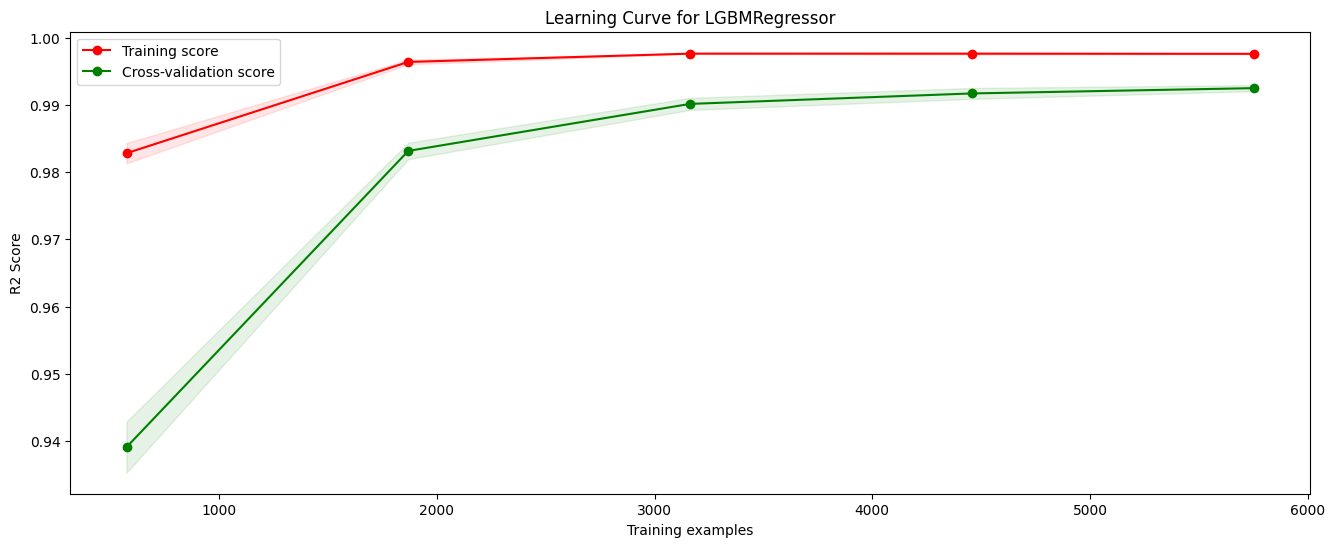

In [55]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    lgb_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(16, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("R2 Score")
plt.legend(loc="best")
plt.title("Learning Curve for LGBMRegressor")
plt.show()

### Model Prediction Objective and Results:

**Objective:**
The model is designed to predict the 'Profit' based on various cleaned and encoded features from the dataset, aiming to understand the contributing factors to profitability and optimize resource allocation accordingly.

**Results:**
R2 Score: This metric is used to measure the proportion of variance in the dependent variable that is predictable from the independent variables. The specific R2 score would tell us how well the unseen data is being predicted by the model.
Residual Plot: The plot provided is instrumental in identifying the variance of residuals against the predicted values. A tightly clustered group around the zero line suggests that the model has a decent fit for the data, although there are some outliers, indicating instances where the model’s predictions deviate significantly from actual values.


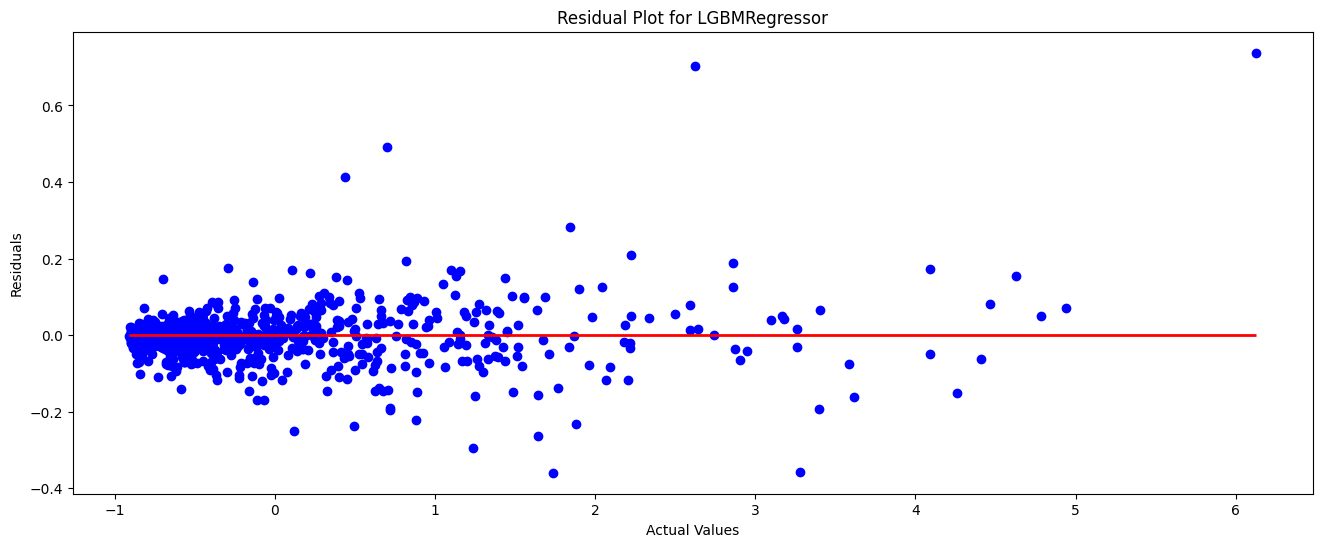

In [56]:
residuals = y_test - y_pred

plt.figure(figsize=(16, 6))
plt.scatter(y_test, residuals, color='blue')
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for LGBMRegressor')
plt.show()

**Summary:**
This model's training and subsequent evaluation reveal how effectively it can predict profit based on company data. The R2 score and residual plot are crucial for understanding model performance and reliability, guiding further refinements to enhance predictive accuracy. The described steps not only demonstrate the model's capabilities but also set the stage for potential operational improvements based on predictive insights.
